In [32]:
# Importing the required libraries
import os
import pprint
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import boto3
import sagemaker
from sagemaker import get_execution_role

from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer
from sagemaker import LinearLearner
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner, CategoricalParameter
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.processing import ProcessingInput, ProcessingOutput

from sklearn.metrics import accuracy_score, balanced_accuracy_score, \
    precision_score, recall_score, f1_score, average_precision_score, \
    roc_auc_score, roc_curve

In [7]:
# Initialize required variables
session = sagemaker.Session()
role = get_execution_role()
bucket = session.default_bucket()

In [15]:
# Create dictionary with the data for each offer type
output_configs = {}

for target_name in ['bogo', 'discount', 'info']:
    print(target_name)
    
    sklearn_processor = SKLearnProcessor(framework_version='0.23-1',
                                         role=role,
                                         instance_type='ml.m5.xlarge',
                                         instance_count=1)
    sklearn_processor.run(
        code='model_utils/preprocess.py',
        inputs=[ProcessingInput(os.path.join('s3://', 
        bucket, f'CapstoneProjectStarbucks/{target_name}.csv'), 
        '/opt/ml/processing/input')],
        outputs=[
            ProcessingOutput(source=f'/opt/ml/processing/output/',
                             output_name=f'{target_name}_data')
        ],
        arguments=['--target', target_name]
     )

    preprocessing_job_description = sklearn_processor.jobs[-1].describe()
    output_configs[target_name] = preprocessing_job_description[
                                                    'ProcessingOutputConfig']

bogo

Job Name:  sagemaker-scikit-learn-2021-10-31-12-23-14-283
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-847508660735/CapstoneProjectStarbucks/bogo.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-847508660735/sagemaker-scikit-learn-2021-10-31-12-23-14-283/input/code/preprocess.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'bogo_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-847508660735/sagemaker-scikit-learn-2021-10-31-12-23-14-283/output/bogo_data', 'LocalPath': '/opt/ml/processing/output/', 'S3UploadMode': 'EndOfJob'}}]
..........


info

Job Name:  sagemaker-scikit-learn-2021-10-31-12-32-40-415
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-847508660735/CapstoneProjectStarbucks/info.csv', 'LocalPath': '/opt/ml/processing/input', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-847508660735/sagemaker-scikit-learn-2021-10-31-12-32-40-415/input/code/preprocess.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'info_data', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-847508660735/sagemaker-scikit-learn-2021-10-31-12-32-40-415/output/info_data', 'LocalPath': '/opt/ml/processing/output/', 'S3UploadMode': 'EndOfJob'}}]
.........

In [16]:
# Get location on S3
preprocessed_data = {}

for output in output_configs:
    preprocessed_data[output] = \
            output_configs[output]['Outputs'][0]['S3Output']['S3Uri']

# Move datasets to Project folder
s3_client = boto3.client('s3')
for k in preprocessed_data:
    for f in ['train.csv', 'val.csv', 'test.csv', 'test_target.csv', 
              'transformer.joblib']:
        copy_source = {'Bucket': bucket, 
           'Key': '/'.join(preprocessed_data[k][5:].split('/')[1:] + \
                                                       [f'{k}_{f}'])}
        s3_client.copy_object(CopySource=copy_source, 
                  Bucket=bucket, Key=f'CapstoneProjectStarbucks/{k}/{k}_{f}')

# Download the preprocessed datasets
for k in preprocessed_data:
    for f in ['train.csv', 'val.csv', 'test.csv', 'test_target.csv']:
        session.download_data(f'./data/{k}/', bucket, 
                              f'CapstoneProjectStarbucks/{k}/{k}_{f}')

In [17]:
# This dataset will contain all the information about the developed models
best_model = {'bogo': {}, 'discount': {}, 'info': {}}

In [21]:
# Set the model image
container = get_image_uri(session.boto_region_name, 'xgboost', '0.90-1')

for prefix in ['bogo', 'discount', 'info']:
    # Initialize XGBoost
    xgb = sagemaker.estimator.Estimator(container,
        role,
        train_instance_count=1,
        train_instance_type='ml.c4.xlarge',
        output_path=f's3://{bucket}/CapstoneProjectStarbucks/{prefix}/model',
        sagemaker_session=session,
        base_job_name=prefix + '-')
    
    xgb.set_hyperparameters(max_depth=4,
                            eta=0.1,
                            gamma=4,
                            min_child_weight=6,
                            colsample_bytree=0.5,
                            subsample=0.6,
                            early_stopping_rounds=10,
                            num_round=200,
                            seed=1)

    # Initialize Tuner
    xgb_hyperparameter_tuner = HyperparameterTuner(estimator=xgb,
                   objective_metric_name='validation:f1',
                   objective_type='Maximize',
                   max_jobs=20,
                   max_parallel_jobs=4,
                   hyperparameter_ranges = {
                        'max_depth': IntegerParameter(2, 6),
                        'eta'      : ContinuousParameter(0.01, 0.5),
                        'gamma': ContinuousParameter(0, 10),
                        'min_child_weight': IntegerParameter(2, 8),
                        'colsample_bytree': ContinuousParameter(0.2, 1.0),
                        'subsample': ContinuousParameter(0.3, 1.0),
                   },
                   base_tuning_job_name=prefix + '-xgb-tuning')

    
    # Take train and validation folders on S3
    s3_input_train = sagemaker.inputs.TrainingInput(
        s3_data=f's3://{bucket}/CapstoneProjectStarbucks/{prefix}/{prefix}_train.csv', content_type='csv')
    s3_input_validation = sagemaker.inputs.TrainingInput(
        s3_data=f's3://{bucket}/CapstoneProjectStarbucks/{prefix}/{prefix}_val.csv', content_type='csv')

    # Fit the Tuner
    xgb_hyperparameter_tuner.fit({'train': s3_input_train, 
                                  'validation': s3_input_validation})
    
    print(f'Waiting {prefix}...')
    xgb_hyperparameter_tuner.wait()

    # Save results and the best model
    best_model[prefix]['xgb'] = {'name': 
         xgb_hyperparameter_tuner.best_training_job(),
         'value': 
         xgb_hyperparameter_tuner.analytics().dataframe()[\
                                          'FinalObjectiveValue'].max()}

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


...............................................................................................................................................................................................................................................................!
Waiting bogo...
!


train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


...........................................................................................................................................................................................................................................................!
Waiting discount...
!

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.



..............................................................................................................................................................................................................................................................!
Waiting info...
!


In [24]:
# Retrain the best model
for prefix in ['bogo', 'discount', 'info']:
    print(prefix)
    
    tuner = sagemaker.estimator.Estimator.attach(\
                                 best_model[prefix]['xgb']['name'])
    
    s3_input_train = sagemaker.inputs.TrainingInput(\
                    s3_data=f's3://{bucket}/CapstoneProjectStarbucks/{prefix}/{prefix}_train.csv', content_type='csv')
    s3_input_validation = sagemaker.inputs.TrainingInput(\
                     s3_data=f's3://{bucket}/CapstoneProjectStarbucks/{prefix}/{prefix}_val.csv', 
                                             content_type='csv')

    tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

    best_model[prefix]['xgb']['model'] = tuner

bogo

2021-10-31 13:00:49 Starting - Preparing the instances for training
2021-10-31 13:00:49 Downloading - Downloading input data
2021-10-31 13:00:49 Training - Training image download completed. Training in progress.
2021-10-31 13:00:49 Uploading - Uploading generated training model
2021-10-31 13:00:49 Completed - Training job completed
2021-10-31 15:38:25 Starting - Starting the training job...
2021-10-31 15:38:48 Starting - Launching requested ML instancesProfilerReport-1635694705: InProgress
......
2021-10-31 15:39:48 Starting - Preparing the instances for training.........
2021-10-31 15:41:12 Downloading - Downloading input data...
2021-10-31 15:41:49 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:f1 to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed

Training seconds: 61
Billable seconds: 61


In [25]:
# Train the Linear Model
for prefix in ['bogo', 'discount', 'info']:
    # Create instance of LinearLearner
    ll = LinearLearner(role,
           train_instance_count=1, 
           train_instance_type='ml.c4.xlarge',
           predictor_type='binary_classifier',
           output_path='s3://{}/CapstoneProjectStarbucks/{}/model'.format(\
                                                          bucket, prefix),
           sagemaker_session=session,
           binary_classifier_model_selection_criteria='f1',
           epochs=100,
           use_bias=True,
           optimizer='adam',
           loss='auto',
           wd=0,
           normalize_data=True,
           unbias_data=True,
           early_stopping_patience=5,
           learning_rate=0.01,
           balance_multiclass_weights=True)
    
    # Create Sets from the local data as the inputs to the Linear model
    train = pd.read_csv(f'./data/{prefix}/{prefix}_train.csv', header=None)
    train_data = ll.record_set(train.drop(0, 1).values.astype('float32'), 
                   labels=train[0].values.astype('float32'), channel='train')
    
    valid = pd.read_csv(f'./data/{prefix}/{prefix}_train.csv', header=None)
    validation_data = ll.record_set(valid.drop(0, 1).values.astype('float32'), 
                labels=valid[0].values.astype('float32'), channel='validation')

    # Fit the model
    ll.fit([train_data, validation_data], logs=False)

    # Save results
    tja = ll.training_job_analytics
    res = tja.dataframe()
    best_model[prefix]['ll'] = {'name': tja.name,
        'value': res.loc[res['metric_name'] == 'validation:binary_f_beta', 
                         'value'].values[0],
        'model': ll}

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.



2021-10-31 15:50:14 Starting - Starting the training job.
2021-10-31 15:50:22 Starting - Launching requested ML instances..........
2021-10-31 15:51:18 Starting - Preparing the instances for training.........................
2021-10-31 15:53:27 Downloading - Downloading input data..
2021-10-31 15:53:45 Training - Downloading the training image...
2021-10-31 15:54:05 Training - Training image download completed. Training in progress...........................
2021-10-31 15:56:17 Uploading - Uploading generated training model
2021-10-31 15:56:25 Completed - Training job completed

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.



2021-10-31 15:56:27 Starting - Starting the training job
2021-10-31 15:56:29 Starting - Launching requested ML instances...............
2021-10-31 15:57:52 Starting - Preparing the instances for training..........................
2021-10-31 16:00:05 Downloading - Downloading input data..
2021-10-31 16:00:23 Training - Downloading the training image....
2021-10-31 16:00:45 Training - Training image download completed. Training in progress...................
2021-10-31 16:02:23 Uploading - Uploading generated training model.
2021-10-31 16:02:32 Completed - Training job completed

train_instance_count has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
train_instance_type has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.



2021-10-31 16:02:36 Starting - Starting the training job
2021-10-31 16:02:39 Starting - Launching requested ML instances............
2021-10-31 16:03:46 Starting - Preparing the instances for training.......................
2021-10-31 16:05:45 Downloading - Downloading input data
2021-10-31 16:05:51 Training - Downloading the training image...
2021-10-31 16:06:12 Training - Training image download completed. Training in progress................
2021-10-31 16:07:29 Uploading - Uploading generated training model
2021-10-31 16:07:37 Completed - Training job completed

We see that for Bogo and Discount XGB provides the best result, while for Informational offer the Linear model is the most suiting one.

In [26]:
# Print the best model
pprint.pprint(best_model)

{'bogo': {'ll': {'model': <sagemaker.amazon.linear_learner.LinearLearner object at 0x7f5c44adfcf8>,
                 'name': 'linear-learner-2021-10-31-15-50-14-130',
                 'value': 0.7183136412459721},
          'xgb': {'model': <sagemaker.estimator.Estimator object at 0x7f5c4791afd0>,
                  'name': 'bogo-xgb-tuning-211031-1240-020-6be16c90',
                  'value': 0.7448229789733887}},
 'discount': {'ll': {'model': <sagemaker.amazon.linear_learner.LinearLearner object at 0x7f5c46aef080>,
                     'name': 'linear-learner-2021-10-31-15-56-27-606',
                     'value': 0.712468193384224},
              'xgb': {'model': <sagemaker.estimator.Estimator object at 0x7f5c49297d68>,
                      'name': 'discount-xgb-tuning-211031-1301-020-1a4af985',
                      'value': 0.7358890175819397}},
 'info': {'ll': {'model': <sagemaker.amazon.linear_learner.LinearLearner object at 0x7f5c46aef240>,
                 'name': 'linear-lear

In [28]:
# Create Transformers
for prefix in ['bogo','discount', 'info']:
    print(prefix)

    # Create XGB Transformer
    transformer = best_model[prefix]['ll']['model'].transformer(\
                        instance_count = 1, instance_type = 'ml.m4.xlarge')

    # Batch transform
    transformer.transform(f's3://{bucket}/CapstoneProjectStarbucks/{prefix}/{prefix}_test.csv',
                   content_type='text/csv', split_type='Line', logs=False)
    
    transformer.wait(logs=False)
    
    # Download the data
    session.download_data(f'./data/{prefix}/{prefix}_ll_preds', bucket,
                  key_prefix='/'.join(transformer.output_path.split('/')[3:]))
    
    # Create Linear Transformer
    transformer = best_model[prefix]['xgb']['model'].transformer(\
                     instance_count = 1, instance_type = 'ml.m4.xlarge')

    # Batch transform
    transformer.transform(f's3://{bucket}/CapstoneProjectStarbucks/{prefix}/{prefix}_test.csv',
       content_type='text/csv', split_type='Line', wait=True, logs=False)

    # Download the data
    session.download_data(f'./data/{prefix}/{prefix}_xgb_preds', bucket,
                  key_prefix='/'.join(transformer.output_path.split('/')[3:]))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


bogo
.....................................................................!
!
..................................................................!

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.



discount
......................................................................!
!
....................................................................!
info


Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


....................................................................!
!
...............................................................!


In [39]:
# Create a function to assess the results
def assess_model(y, y_prob, y_pred=None):
    '''
    This function provides performance measures for ML models, given
    the true labels and the predictions. In addition, it plots the 
    ROC Curve and the Confusion Matrix.
    
    Args:
    y (list/numpy.array) - the true labels
    y_prob (list/numpy.array) - model-returned probabilities
    y_pred (list/numpy.array) - Predictions returned by the model.
    
    Outputs:
    res (DataFrame) - dataset contains a list of the most used performance
    measures for the data provided.
    '''

    
    if y_pred is None:
        y_pred = pd.Series([1 if x >= 0.5 else 0 for x in y_prob])
        
    res = pd.DataFrame(
        {'value': [accuracy_score(y, y_pred),
                   balanced_accuracy_score(y, y_pred),
                   precision_score(y, y_pred), recall_score(y, y_pred),
                   f1_score(y, y_pred),
                   average_precision_score(y, y_prob),
                   roc_auc_score(y, y_prob)]
         },
        index=['accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1',
               'average_precision', 'AUC']
    )

    fpr, tpr, _ = roc_curve(y, y_prob)
    plt.plot(fpr, tpr)
    plt.title('ROC Curve')
    plt.show()

    print('Confusion matrix')
    display(pd.crosstab(y, y_pred, normalize='index'))

    return res

bogo Offer
XGBoost Model


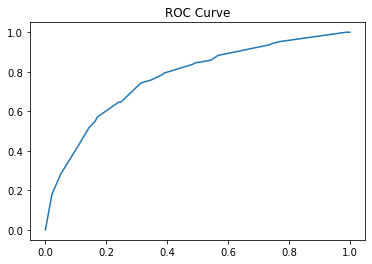

Confusion matrix


col_0,0,1
0,,
0.0,0.685811,0.314189
1.0,0.256757,0.743243


,value
accuracy,0.714527
balanced_accuracy,0.714527
precision,0.702875
recall,0.743243
f1,0.722496
average_precision,0.751441
AUC,0.770225


LinearLearner Model


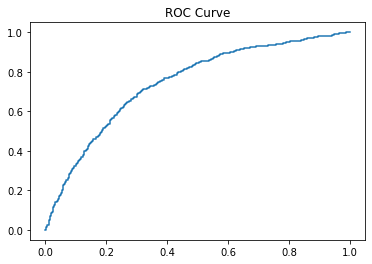

Confusion matrix


col_0,0,1
0,,
0.0,0.457207,0.542793
1.0,0.140766,0.859234


,value
accuracy,0.658221
balanced_accuracy,0.658221
precision,0.612851
recall,0.859234
f1,0.715424
average_precision,0.711542
AUC,0.743128





discount Offer
XGBoost Model


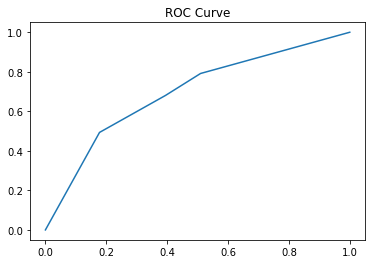

Confusion matrix


col_0,0,1
0,,
0.0,0.822266,0.177734
1.0,0.506823,0.493177


,value
accuracy,0.657561
balanced_accuracy,0.657722
precision,0.735465
recall,0.493177
f1,0.590432
average_precision,0.653268
AUC,0.694937


LinearLearner Model


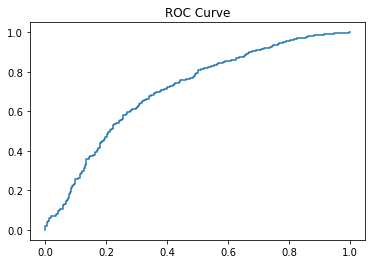

Confusion matrix


col_0,0,1
0,,
0.0,0.460938,0.539062
1.0,0.177388,0.822612


,value
accuracy,0.641951
balanced_accuracy,0.641775
precision,0.604585
recall,0.822612
f1,0.696945
average_precision,0.677121
AUC,0.708409





info Offer
XGBoost Model


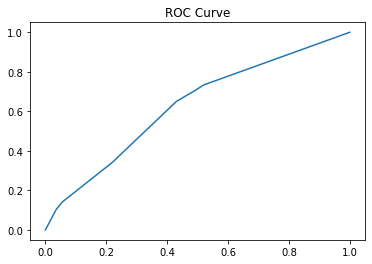

Confusion matrix


col_0,0,1
0,,
0.0,0.569733,0.430267
1.0,0.350148,0.649852


,value
accuracy,0.609792
balanced_accuracy,0.609792
precision,0.601648
recall,0.649852
f1,0.624822
average_precision,0.594362
AUC,0.626267


LinearLearner Model


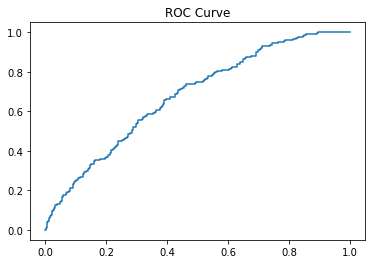

Confusion matrix


col_0,0,1
0,,
0.0,0.308605,0.691395
1.0,0.109792,0.890208


,value
accuracy,0.599407
balanced_accuracy,0.599407
precision,0.562852
recall,0.890208
f1,0.689655
average_precision,0.654555
AUC,0.677253


In [40]:
# Plot the aggregated results
for prefix in ['bogo', 'discount', 'info']:
    print(prefix +' Offer')
    
    # Load True Labels
    y_test = pd.read_csv(f'./data/{prefix}/{prefix}_test_target.csv', 
                         squeeze=True, header=None)
    
    # XGBoost
    print('XGBoost Model')
    y_prob = pd.read_csv(f'./data/{prefix}/{prefix}_xgb_preds/{prefix}_test.csv.out', squeeze=True, header=None)
    display(assess_model(y_test, y_prob))

    # LinearLearner
    print('LinearLearner Model')
    with open(f'./data/{prefix}/{prefix}_ll_preds/{prefix}_test.csv.out', 
                                                                  'r') as f:
        jsons = [json.loads(x.replace('\n', '')) for x in f.readlines()]
    res = pd.DataFrame(jsons)
    display(assess_model(y_test, res['score'].values, y_pred=res[
                                                'predicted_label'].values))
    
    print('\n\n')